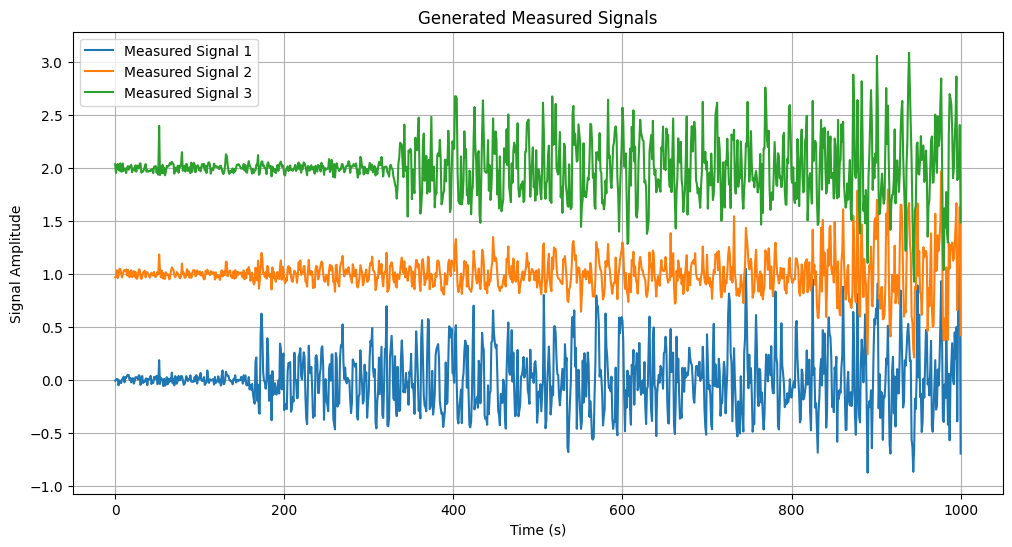

In [109]:
# Import the function to test
from simulate_sEMG import generate_measured_signals
import numpy as np
import matplotlib.pyplot as plt

# Generate dummy control signals
# 5 control signals, each with 5001 time points (5 seconds at 1 ms intervals)
time = np.arange(0, 1.001, 0.001)
num_signals = 5
# Create step functions for control signals
control_signals = np.zeros((num_signals, len(time)), dtype=int)
for idx in range(num_signals):
    # Each signal switches on at a different time
    step_point = int((idx + 1) * len(time) / (num_signals + 1))
    control_signals[idx, step_point:] = 1



# Call the function to generate measured signals
measured_signals = generate_measured_signals(control_signals)

#remove 50point moving average from each signal for better visualization
measured_signals = np.array(measured_signals)
for i in range(measured_signals.shape[0]):
    measured_signals[i] = measured_signals[i] - np.convolve(measured_signals[i], np.ones(20)/20, mode='same')

#add +-0.1 random noise to each signal for better simulation
for i in range(measured_signals.shape[0]):
    noise = np.random.uniform(-0.05, 0.05, size=measured_signals[i].shape)
    measured_signals[i] += noise

# Plot the generated signals
plt.figure(figsize=(12, 6))
for i, signal in enumerate(measured_signals):
    plt.plot( i+signal, label=f'Measured Signal {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Signal Amplitude')
plt.title('Generated Measured Signals')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

from numpy import shape
from tqdm import tqdm


block_len = 1000  # 1 sec at 1 ms intervals
num_blocks = 4000   # 3000 blocks for training
num_signals = 5



# Generate measured signals block by block and concatenate
train_measured_blocks = []
control_signals_blocks = []
for b in tqdm(range(num_blocks)):
    # random 5 binary control signals, each has random changes from 0 to 3 in a block
    control_signals = np.zeros((num_signals, len(time)), dtype=int)
    for idx in range(num_signals):
        # Each signal switches on at a different time
        # Randomly choose a step point for each signal in the block
        step_point = np.random.randint(0, len(time))
        control_signals[idx, step_point:] = 1

    block_measured = generate_measured_signals(control_signals)
    block_measured = block_measured - np.array([np.convolve(block_measured[i], np.ones(20)/20, mode='same') for i in range(shape(block_measured)[0])])# remove 20point moving average
    # add +-0.1 random noise to each signal for better simulation
    for i in range(shape(block_measured)[0]):
        noise = np.random.uniform(-0.005, 0.005, size=block_measured[i].shape)
        block_measured[i] += noise
    train_measured_blocks.append(np.array(block_measured))
    control_signals_blocks.append(control_signals)
train_measured = np.concatenate(train_measured_blocks, axis=1)
train_control = np.concatenate(control_signals_blocks, axis=1)

# save train_measured and train_control numpy arrays
np.save('train_measured.npy', train_measured)
np.save('train_control.npy', train_control)


100%|██████████| 4000/4000 [00:05<00:00, 674.00it/s]


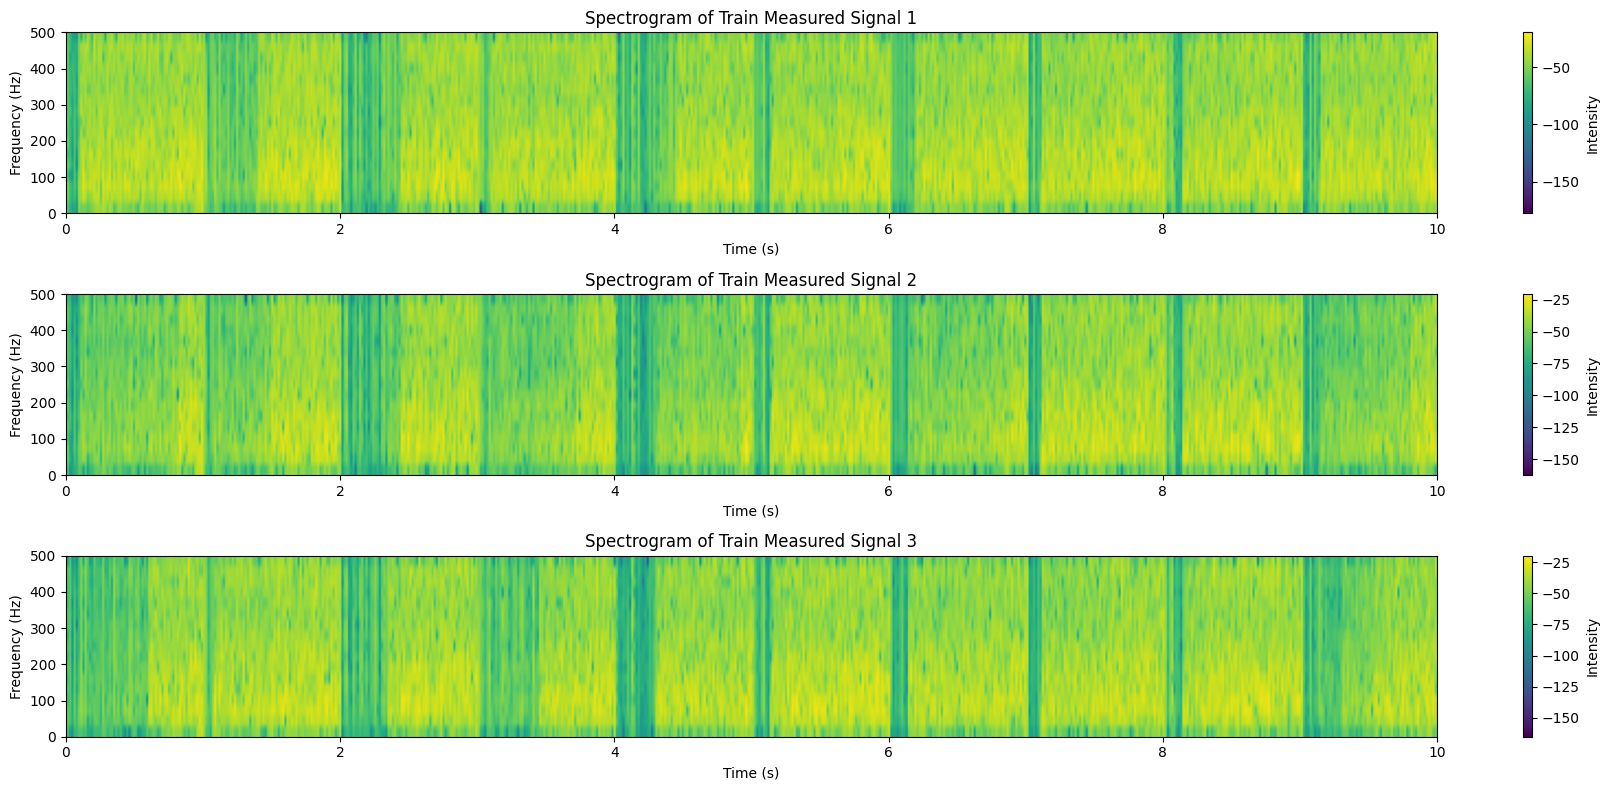

In [113]:
plt.figure(figsize=(18, 8))
for i in range(train_measured.shape[0]):
    plt.subplot(train_measured.shape[0], 1, i+1)
    plt.specgram(train_measured[i], NFFT=32, Fs=1/0.001, noverlap=16, cmap='viridis')
    plt.title(f'Spectrogram of Train Measured Signal {i+1}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(0, 500)
    plt.xlim(0, 10)
    plt.colorbar(label='Intensity')
plt.tight_layout()
plt.show()

Epoch 1/20, Loss: 0.3984
Epoch 2/20, Loss: 0.3855
Epoch 3/20, Loss: 0.3839
Epoch 4/20, Loss: 0.3833
Epoch 5/20, Loss: 0.3829
Epoch 6/20, Loss: 0.3827
Epoch 7/20, Loss: 0.3825
Epoch 8/20, Loss: 0.3820
Epoch 9/20, Loss: 0.3820
Epoch 10/20, Loss: 0.3820
Epoch 11/20, Loss: 0.3818
Epoch 12/20, Loss: 0.3816
Epoch 13/20, Loss: 0.3815
Epoch 14/20, Loss: 0.3815
Epoch 15/20, Loss: 0.3815
Epoch 16/20, Loss: 0.3815
Epoch 17/20, Loss: 0.3814
Epoch 18/20, Loss: 0.3813
Epoch 19/20, Loss: 0.3813
Epoch 20/20, Loss: 0.3814


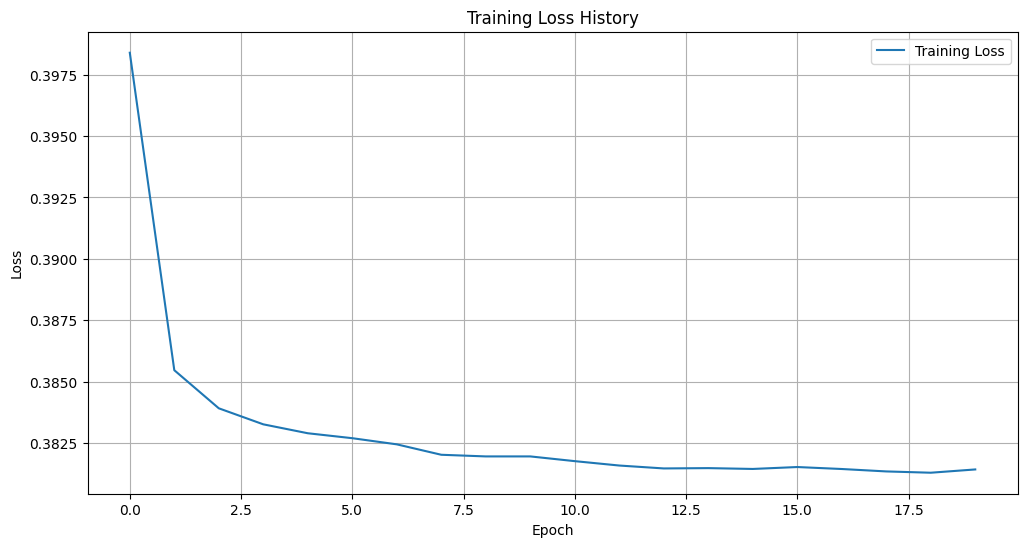

In [114]:
import torch

import torch.nn as nn
import torch.optim as optim

# Prepare data for NN: measured_signals (input), control_signals (target)
# measured_signals: shape (3, time_steps), control_signals: shape (5, time_steps)
X = torch.tensor(train_measured.T, dtype=torch.float32)  # shape: (time_steps, 3)
y = torch.tensor(train_control.T, dtype=torch.float32)   # shape: (time_steps, 5)

# Define a simple feedforward NN
class SignalReconstructor(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

model = SignalReconstructor()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

batch_size = 1024
epochs = 20
loss_history = []

for epoch in range(epochs):
    permutation = torch.randperm(X.size(0))
    epoch_loss = 0.0
    for i in range(0, X.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_X, batch_y = X[indices], y[indices]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    loss_history.append(epoch_loss / X.size(0))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/X.size(0):.4f}")

# Predict reconstructed control signals
reconstructed = model(X).detach().numpy()

#plot loss history
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss History')
plt.legend()
plt.grid(True)
plt.show()

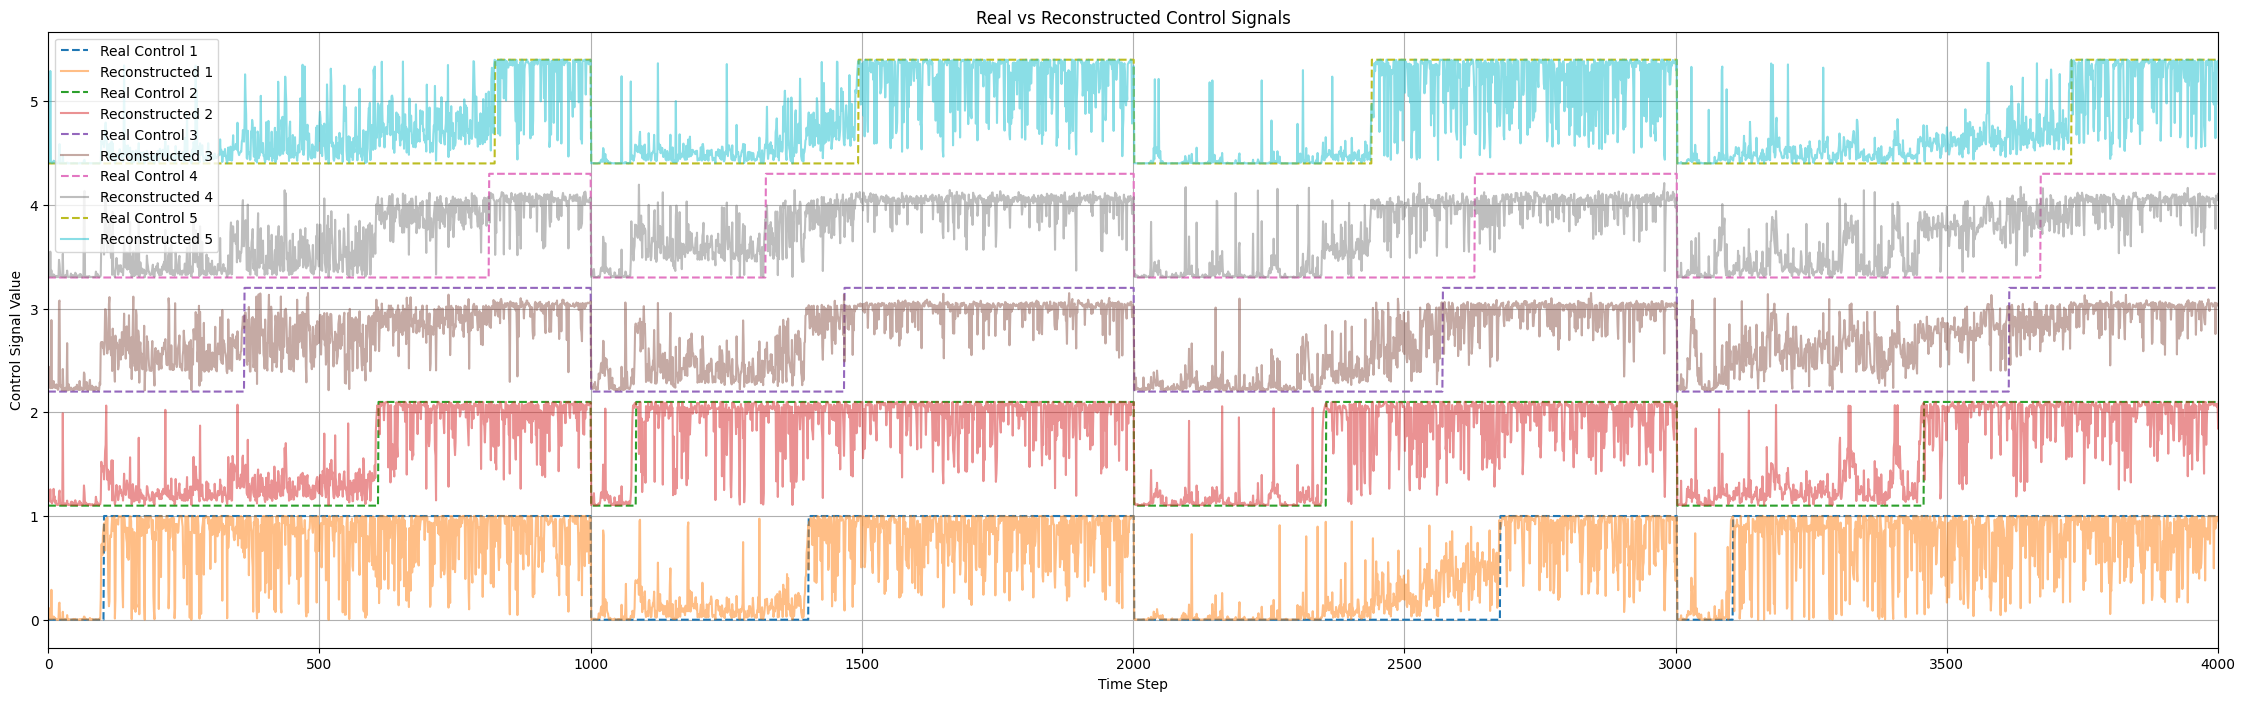

In [115]:
plt.figure(figsize=(28, 8))
x_axis = np.arange(train_control.shape[1])
for i in range(num_signals):
    plt.plot(x_axis, i*1.1+train_control[i], label=f'Real Control {i+1}', linestyle='--')
    plt.plot(x_axis, i*1.1+reconstructed[:, i], label=f'Reconstructed {i+1}', alpha=0.5)
plt.xlabel('Time Step')
plt.ylabel('Control Signal Value')
plt.title('Real vs Reconstructed Control Signals')
plt.legend()
plt.xlim([0, 4000])
plt.grid(True)
plt.show()

Thresholded reconstruction accuracy: 90.99%


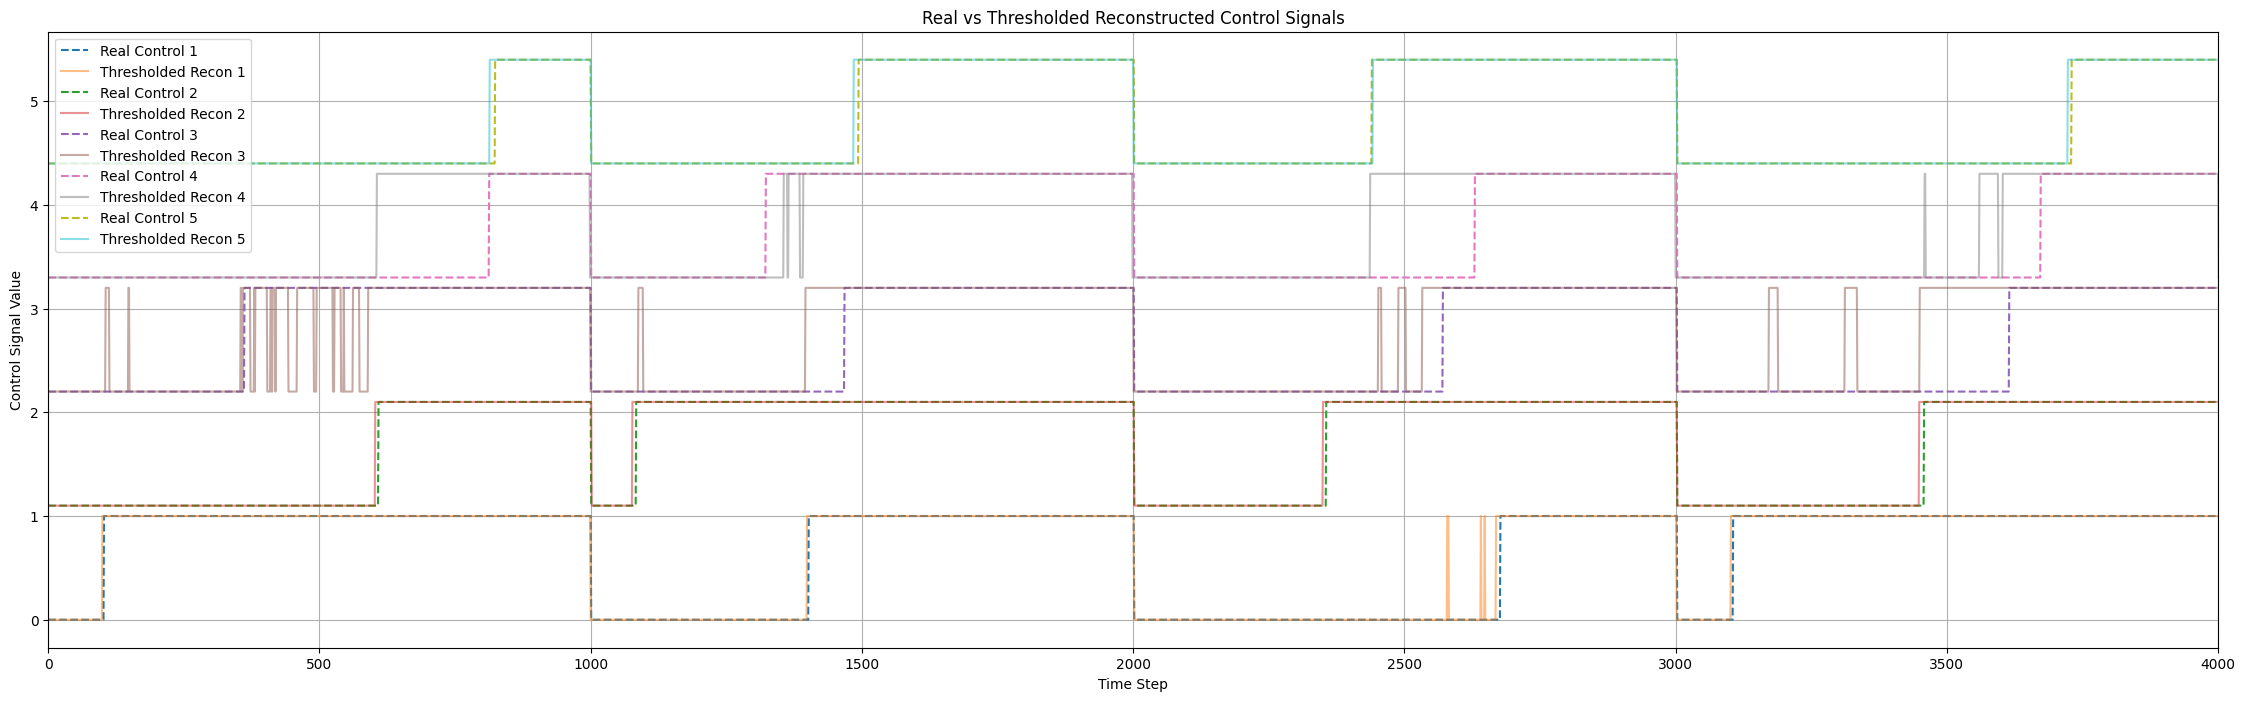

In [116]:
# Moving average and threshold the reconstructed output
window_size = 20
smoothed_reconstructed = np.zeros_like(reconstructed)
for i in range(num_signals):
    smoothed_reconstructed[:, i] = np.convolve(reconstructed[:, i], np.ones(window_size)/window_size, mode='same')
thresholded_reconstructed = (smoothed_reconstructed > 0.5).astype(int)

# Calculate accuracy
accuracy = (thresholded_reconstructed == train_control.T).mean() * 100
print(f"Thresholded reconstruction accuracy: {accuracy:.2f}%")

# Plot real vs thresholded reconstructed control signals
plt.figure(figsize=(28, 8))
for i in range(num_signals):
    plt.plot(x_axis, i*1.1+train_control[i], label=f'Real Control {i+1}', linestyle='--')
    plt.plot(x_axis, i*1.1+thresholded_reconstructed[:, i], label=f'Thresholded Recon {i+1}', alpha=0.5)
plt.xlabel('Time Step')
plt.ylabel('Control Signal Value')
plt.title('Real vs Thresholded Reconstructed Control Signals')
plt.legend()
plt.xlim([0, 4000])
plt.grid(True)
plt.show()

EDGEIMPULSE


In [23]:
import os
import numpy as np
# Import the function to test
from simulate_sEMG import generate_measured_signals
import matplotlib.pyplot as plt

n = 100  # number of samples for each set
output_folder = "special_control_sets"
time = np.arange(0, 1.001, 0.001)

os.makedirs(output_folder, exist_ok=True)

# All zeros (open)
open_control = np.zeros((5, len(time)), dtype=int)
open_measured = []
for i in range(n):
    measured = generate_measured_signals(open_control)
    measured = measured - np.array([np.convolve(measured[j], np.ones(20)/20, mode='same') for j in range(3)])
    noise = np.random.uniform(-0.1, 0.1, size=measured.shape)
    measured += noise
    open_measured.append(measured)
    # Stack time as the first column
    data_to_save = np.column_stack((time * 1000, measured.T))
    np.savetxt(f"{output_folder}/open.{i}.csv", data_to_save, delimiter=",", header="timestamp,ch1,ch2,ch3", comments='')

closed_control = np.ones((5, len(time)), dtype=int)
closed_measured = []
for i in range(n):
    measured = generate_measured_signals(closed_control)
    measured = measured - np.array([np.convolve(measured[j], np.ones(20)/20, mode='same') for j in range(3)])
    noise = np.random.uniform(-0.1, 0.1, size=measured.shape)
    measured += noise
    closed_measured.append(measured)
    data_to_save = np.column_stack((time * 1000, measured.T))
    np.savetxt(f"{output_folder}/closed.{i}.csv", data_to_save, delimiter=",", header="timestamp,ch1,ch2,ch3", comments='')


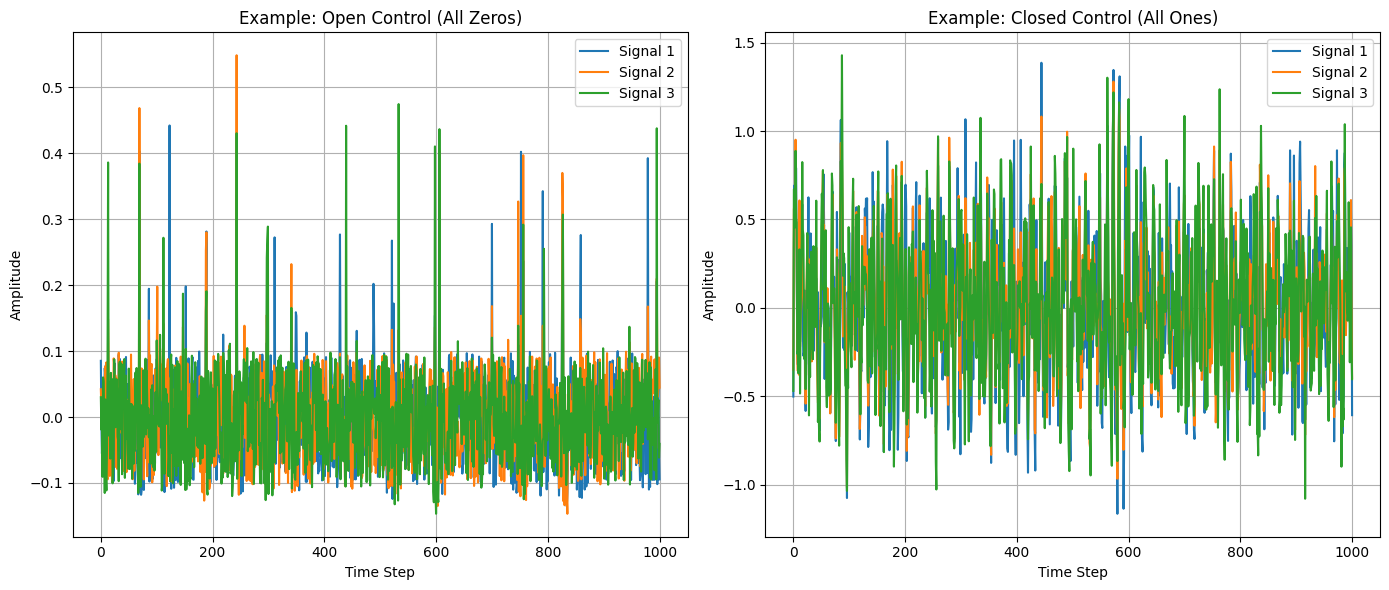

In [24]:
# Display example measured signals for "open" and "closed" control sets
plt.figure(figsize=(14, 6))

# Plot one example from open_measured
plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(open_measured[0][i], label=f'Signal {i+1}')
plt.title('Example: Open Control (All Zeros)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Plot one example from closed_measured
plt.subplot(1, 2, 2)
for i in range(3):
    plt.plot(closed_measured[0][i], label=f'Signal {i+1}')
plt.title('Example: Closed Control (All Ones)')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()